In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import recall_score
import numpy as np
from keras.callbacks import Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import time
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_mayor = "/content/drive/MyDrive/Colab Notebooks/IS_based_VLP_Dataset"

In [ ]:
ruta_sigle_led = "/VLP_Single_LED/VLP_Single_LED"

In [ ]:
total_ruta_single_led = ruta_mayor + ruta_sigle_led
print(total_ruta_single_led)

/content/drive/MyDrive/Colab Notebooks/IS_based_VLP_Dataset/VLP_Single_LED/VLP_Single_LED


In [ ]:
# Número de folds
k_folds = 5

# Paso 2: Crear el objeto StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=123)

# Listas para almacenar las métricas
test_accuracies = []
test_gmeans = []
time_ = []

In [ ]:
# Tamaño del lote
batch_size = 64

# Número de épocas
epochs = 30

# Paso 1: Obtener las rutas de las imágenes y las etiquetas
image_paths = []
labels = []

In [ ]:
# Obtener los nombres de las clases
class_names = sorted(os.listdir(total_ruta_single_led))
class_indices = dict((name, index) for index, name in enumerate(class_names))
print(class_names)
print(class_indices)

['LED11', 'LED12', 'LED13', 'LED14', 'LED3', 'LED4', 'LED7', 'LED8']
{'LED11': 0, 'LED12': 1, 'LED13': 2, 'LED14': 3, 'LED3': 4, 'LED4': 5, 'LED7': 6, 'LED8': 7}


In [ ]:
for class_name in class_names:
    class_dir = os.path.join(total_ruta_single_led, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar solo imágenes
                fpath = os.path.join(class_dir, fname)
                image_paths.append(fpath)
                labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)
num_classes = len(class_names)
print("Total de imágenes:", len(image_paths))
print("Clases:", class_names)

Total de imágenes: 2840
Clases: ['LED11', 'LED12', 'LED13', 'LED14', 'LED3', 'LED4', 'LED7', 'LED8']


In [ ]:
def preprocess_image(path, label):
    # Leer y decodificar la imagen
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    # Redimensionar la imagen
    image = tf.image.resize(image, [150, 150])
    # Aplicar normalización Min-Max
    image = image / tf.math.reduce_max(tf.reshape(image, [-1, image.shape[-1]]), axis=0)
    return image, label

In [ ]:
# Definir el callback para G-mean
class GMeanCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(GMeanCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred_classes = []

        for X_val_batch, y_val_batch in self.validation_data:
            y_pred_batch = self.model.predict(X_val_batch)
            y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

            y_true.extend(y_val_batch.numpy())
            y_pred_classes.extend(y_pred_classes_batch)

        y_true = np.array(y_true)
        y_pred_classes = np.array(y_pred_classes)

        recalls = recall_score(y_true, y_pred_classes, average=None)
        gmean = np.prod(recalls) ** (1.0 / len(recalls))

        logs['val_gmean'] = gmean
        print(f" - val_gmean: {gmean:.4f}")

In [ ]:
def print_class_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Distribución de clases en {dataset_name}: {distribution}")

In [ ]:
# Paso 1: Obtener las rutas de las imágenes y las etiquetas
image_paths = []
labels_list = []

# Obtener los nombres de las clases
class_names = sorted(os.listdir(total_ruta_single_led))
class_indices = dict((name, index) for index, name in enumerate(class_names))

for class_name in class_names:
    class_dir = os.path.join(total_ruta_single_led, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar solo imágenes
                fpath = os.path.join(class_dir, fname)
                image_paths.append(fpath)
                labels_list.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels_list)  # labels es un array de NumPy
num_classes = len(class_names)
print("Total de imágenes:", len(image_paths))
print("Clases:", class_names)
print(f"Tipo de labels: {type(labels)}")  # Debería ser <class 'numpy.ndarray'>

Total de imágenes: 2840
Clases: ['LED11', 'LED12', 'LED13', 'LED14', 'LED3', 'LED4', 'LED7', 'LED8']
Tipo de labels: <class 'numpy.ndarray'>


In [ ]:
"""
for fold, (train_index, test_index) in enumerate(skf.split(image_paths, labels), 1):

    start_time = time.time()
    print(f"\n----- Fold {fold} de {k_folds} -----")
    print(f"Tipo de labels al inicio del fold {fold}: {type(labels)}")  # Nueva línea

    # Dividir las rutas y etiquetas en entrenamiento y prueba
    X_train_paths, X_test_paths = image_paths[train_index], image_paths[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Paso 3: Dividir el conjunto de entrenamiento en entrenamiento y validación de manera estratificada
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=123)
    for train_idx, val_idx in sss.split(X_train_paths, y_train):
        X_train_fold, X_val_fold = X_train_paths[train_idx], X_train_paths[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Reemplazar las variables con las nuevas divisiones
    X_train_paths = X_train_fold
    y_train = y_train_fold
    X_val_paths = X_val_fold
    y_val = y_val_fold

    # Imprimir la distribución de clases
    print_class_distribution(y_train, "Entrenamiento")
    print_class_distribution(y_val, "Validación")
    print_class_distribution(y_test, "Prueba")

    # Paso 4: Crear datasets de TensorFlow a partir de las rutas y etiquetas
    AUTOTUNE = tf.data.AUTOTUNE

    # Crear datasets sin sobrescribir labels_array
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))

    # Aplicar preprocesamiento y batching
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.cache() \
                       .shuffle(buffer_size=1000) \
                       .batch(batch_size) \
                       .prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache() \
                   .batch(batch_size) \
                   .prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size) \
                     .prefetch(buffer_size=AUTOTUNE)

    # Paso 5: Definir y compilar el modelo

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics= ['accuracy'])

    gmean_callback = GMeanCallback(validation_data=val_ds)

    # Paso 6: Entrenar el modelo
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[gmean_callback],
        verbose=1  # Puedes establecer verbose=0 para silenciar la salida
    )

    # Paso 7: Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Exactitud en prueba: {test_accuracy:.4f}")

    # Calcular la G-mean en el conjunto de prueba
    y_true = []
    y_pred_classes = []

    for images, labels1 in test_ds:
        y_true.extend(labels1.numpy())
        y_pred = model.predict(images)
        y_pred_classes_batch = np.argmax(y_pred, axis=1)
        y_pred_classes.extend(y_pred_classes_batch)

    y_true = np.array(y_true)
    y_pred_classes = np.array(y_pred_classes)

    end_time = time.time()

    recalls = recall_score(y_true, y_pred_classes, average=None)
    gmean = np.prod(recalls) ** (1.0 / len(recalls))
    print(f"G-mean en prueba: {gmean:.4f}")

    # Almacenar las métricas
    test_accuracies.append(test_accuracy)
    test_gmeans.append(gmean)
    time_.append(end_time - start_time)
  """

'\nfor fold, (train_index, test_index) in enumerate(skf.split(image_paths, labels), 1):\n\n    start_time = time.time()\n    print(f"\n----- Fold {fold} de {k_folds} -----")\n    print(f"Tipo de labels al inicio del fold {fold}: {type(labels)}")  # Nueva línea\n\n    # Dividir las rutas y etiquetas en entrenamiento y prueba\n    X_train_paths, X_test_paths = image_paths[train_index], image_paths[test_index]\n    y_train, y_test = labels[train_index], labels[test_index]\n\n    # Paso 3: Dividir el conjunto de entrenamiento en entrenamiento y validación de manera estratificada\n    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=123)\n    for train_idx, val_idx in sss.split(X_train_paths, y_train):\n        X_train_fold, X_val_fold = X_train_paths[train_idx], X_train_paths[val_idx]\n        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]\n\n    # Reemplazar las variables con las nuevas divisiones\n    X_train_paths = X_train_fold\n    y_train = y_tra

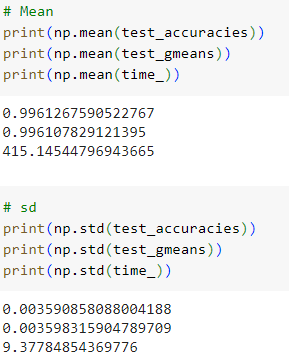

In [ ]:
# Mean
"""
print(np.mean(test_accuracies))
print(np.mean(test_gmeans))
print(np.mean(time_))
"""

'\nprint(np.mean(test_accuracies))\nprint(np.mean(test_gmeans))\nprint(np.mean(time_))\n'

In [ ]:
# sd
"""
print(np.std(test_accuracies))
print(np.std(test_gmeans))
print(np.std(time_))
"""

'\nprint(np.std(test_accuracies))\nprint(np.std(test_gmeans))\nprint(np.std(time_))\n'

In [ ]:
# Número de folds
k_folds = 5

# Mezclar los datos antes del proceso de K-Fold
image_paths, labels = shuffle(image_paths, labels, random_state=123)

# Paso 2: Crear el objeto StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=123)

# Listas para almacenar las métricas
test_accuracies = []
test_gmeans = []
time_ = []

for fold, (train_index, test_index) in enumerate(skf.split(image_paths, labels), 1):

    start_time = time.time()
    print(f"\n----- Fold {fold} de {k_folds} -----")
    print(f"Tipo de labels al inicio del fold {fold}: {type(labels)}")  # Nueva línea

    # Dividir las rutas y etiquetas en entrenamiento y prueba
    X_train_paths, X_test_paths = image_paths[train_index], image_paths[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Imprimir la distribución de clases
    print_class_distribution(y_train, "Entrenamiento")
    print_class_distribution(y_test, "Test")

    # Paso 4: Crear datasets de TensorFlow a partir de las rutas y etiquetas
    AUTOTUNE = tf.data.AUTOTUNE

    # Crear datasets sin sobrescribir labels_array
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))

    # Aplicar preprocesamiento y batching
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.cache() \
                       .shuffle(buffer_size=1000) \
                       .batch(batch_size) \
                       .prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size) \
                     .prefetch(buffer_size=AUTOTUNE)

    # Paso 5: Definir y compilar el modelo

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Paso 6: Entrenar el modelo
    history = model.fit(
        train_ds,
        epochs=epochs,
        verbose=1  # Puedes establecer verbose=0 para silenciar la salida
    )

    # Paso 7: Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Exactitud en prueba: {test_accuracy:.4f}")

    # Calcular la G-Mean en el conjunto de prueba
    y_true = []
    y_pred_classes = []

    for images, labels1 in test_ds:
        y_true.extend(labels1.numpy())
        y_pred = model.predict(images)
        y_pred_classes_batch = np.argmax(y_pred, axis=1)
        y_pred_classes.extend(y_pred_classes_batch)

    y_true = np.array(y_true)
    y_pred_classes = np.array(y_pred_classes)

    end_time = time.time()

    # Guardar y_true y y_pred_classes en archivos de texto
    np.savetxt(f'y_true_fold_{fold}.txt', y_true, fmt='%d')
    np.savetxt(f'y_pred_classes_fold_{fold}.txt', y_pred_classes, fmt='%d')

    cm = confusion_matrix(y_true, y_pred_classes)
    L = cm.shape[0]  # Número de clases

    beta_i = []

    for i in range(L):
        # Verdaderos positivos para la clase i
        true_positives = cm[i, i]
        # Total de muestras reales de la clase i
        total_actual = np.sum(cm[i, :])
        beta = true_positives / total_actual if total_actual > 0 else 0
        beta_i.append(beta)

    beta_i = np.array(beta_i)

    # Calcular G-Mean
    product_beta = np.prod(beta_i)
    gmean = product_beta ** (1 / L)

    print(f"Exactitud por clase (beta_i): {beta_i}")
    print(f"G-mean en prueba: {gmean:.4f}")

    # Almacenar las métricas
    test_accuracies.append(test_accuracy)
    test_gmeans.append(gmean)
    time_.append(end_time - start_time)


----- Fold 1 de 5 -----
Tipo de labels al inicio del fold 1: <class 'numpy.ndarray'>
Distribución de clases en Entrenamiento: {0: 285, 1: 284, 2: 283, 3: 281, 4: 286, 5: 285, 6: 283, 7: 285}
Distribución de clases en Test: {0: 71, 1: 71, 2: 70, 3: 71, 4: 72, 5: 71, 6: 71, 7: 71}
Epoch 1/30
36/36 [==============================] - 17s 390ms/step - loss: 0.7971 - accuracy: 0.6536
Epoch 2/30
36/36 [==============================] - 14s 384ms/step - loss: 0.3488 - accuracy: 0.8138
Epoch 3/30
36/36 [==============================] - 14s 386ms/step - loss: 0.1293 - accuracy: 0.9934
Epoch 4/30
36/36 [==============================] - 14s 389ms/step - loss: 0.0459 - accuracy: 0.9974
Epoch 5/30
36/36 [==============================] - 14s 390ms/step - loss: 0.0263 - accuracy: 0.9978
Epoch 6/30
36/36 [==============================] - 14s 392ms/step - loss: 0.0190 - accuracy: 0.9974
Epoch 7/30
36/36 [==============================] - 14s 391ms/step - loss: 0.0135 - accuracy: 0.9982
Epoch 8/30
3

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
learning_rate = model.optimizer.learning_rate.numpy()
print("Learning rate:", learning_rate)

Learning rate: 0.001


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
# Mean
print(np.mean(test_accuracies))
print(np.mean(test_gmeans))
print(np.mean(time_))


0.9961267709732056
0.9960997933679747
428.2570034980774


In [ ]:
# std
print(np.std(test_accuracies))
print(np.std(test_gmeans))
print(np.std(time_))

0.0025874858976153436
0.0026131875057960104
1.5676273506567808


In [ ]:
round((428.2570034980774), 4)

428.257